# Introduction

In [1]:
# change to the root directory of the project
import os
if os.getcwd().split("/")[-1] == "examples":
    os.chdir('..')

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2    

In [3]:
try:
    import matplotlib.pyplot as plt
except ImportError:
    import sys
    !{sys.executable} -m pip install matplotlib
    import matplotlib.pyplot as plt

from functools import partial
import numpy as np

from neurolib.models.aln import ALNModel
from neurolib.utils.loadData import Dataset
from neurolib.utils.signal import RatesSignal, BOLDSignal

plt.rcParams['image.cmap'] = 'plasma'

## Run the ALN model

Firstly, let us run a network model given the structural connectivity and fiber lengths.

In [5]:
ds = Dataset("gw")
# simulates the whole-brain model
aln = ALNModel(Cmat = ds.Cmat, Dmat = ds.Dmat)
# Resting state fits
aln.params['mue_ext_mean'] = 1.57
aln.params['mui_ext_mean'] = 1.6
aln.params['sigma_ou'] = 0.09
aln.params['b'] = 5.0
aln.params['duration'] = 0.2*60*1000 
# info: value 0.2*60*1000 is low for testing
# use 5*60*1000 for real simulation
aln.run(chunkwise=True, bold = True)

Now we can cast the modelling result into our `Signal` class. `Signal` is a parent base class for any neuro signal. We also provide three child class for particular signals: `RatesSignal` (for firing rate of the populations), `VoltageSignal` (for average membrane potential of the populations), and `BOLDSignal` (for simulated BOLD). They only differ in name, labels and units. Nothing fancy. Of course, you can implement your own class for your particular results very easily as:

```python
from neurolib.utils.signal import Signal


class PostSynapticCurrentSignal(Signal):
    name = "Population post-synaptic current signal"
    label = "I_syn"
    signal_type = "post_current"
    unit = "mA"
```

and that's it. All useful methods and attributes are directly inhereted from the `Signal` parent.

In [6]:
# Create Signal out of firing rates
fr = RatesSignal.from_model_output(aln, group="", time_in_ms=True)
# optional description
fr.description = "Output of the ALN model with default SC and fiber lengths"

# Create Signal out of BOLD simulated timeseries
bold = BOLDSignal.from_model_output(aln, group="BOLD", time_in_ms=True)
bold.description = "Simulated BOLD of the ALN model with default SC and fiber lengths"

In [7]:
# let's check what's inside
print(fr)
print(bold)

Population firing rate representing rate signal with unit of Hz with user-provided description: `Output of the ALN model with default SC and fiber lengths`. Shape of the signal is (2, 80, 8831) with dimensions ('output', 'space', 'time').
Population blood oxygen level-dependent signal representing bold signal with unit of % with user-provided description: `Simulated BOLD of the ALN model with default SC and fiber lengths`. Shape of the signal is (1, 80, 7) with dimensions ('output', 'space', 'time').


`Signal` automatically computes useful attributes like `dt`, sampling rate, starting and ending times.

In [8]:
# inherent attributes
print("Inherent attributes:")
print(fr.name)
print(fr.label)
print(fr.unit)
print(fr.signal_type)
print(fr.description)

# computed attributes
print("\nComputed attributes:")
print(fr.dt)
print(fr.sampling_frequency)
print(fr.start_time)
print(fr.end_time)
print(fr.shape)

Inherent attributes:
Population firing rate
q
Hz
rate
Output of the ALN model with default SC and fiber lengths

Computed attributes:
0.0001
10000.0
0.0
0.883
(2, 80, 8831)


In [9]:
# internal representation of the signal is just xarray's DataArray
print(fr.data)
# xarray is just pandas on steroids, i.e. it supports multi-dimensional arrays, not only 2D

# if you'd need simple numpy array just call .values on signal's data
print(type(fr.data.values))
print(fr.data.values.shape)

<xarray.DataArray (output: 2, space: 80, time: 8831)>
array([[[1.33261450e-02, 1.36917651e-02, 1.40695947e-02, ...,
         3.48158384e-03, 3.46784876e-03, 3.46133411e-03],
        [6.13965587e-01, 6.25356604e-01, 6.34768740e-01, ...,
         3.59993904e-01, 3.54528049e-01, 3.49018287e-01],
        [6.36038906e-02, 6.35557804e-02, 6.33770702e-02, ...,
         4.42949449e-02, 4.37566338e-02, 4.32171260e-02],
        ...,
        [2.50859629e-03, 2.52563325e-03, 2.54037707e-03, ...,
         8.00547429e-03, 7.78636724e-03, 7.61333390e-03],
        [5.95617787e-02, 6.07513850e-02, 6.20942706e-02, ...,
         3.26872805e-02, 3.33536801e-02, 3.40569905e-02],
        [4.96090615e-02, 4.84730168e-02, 4.73428175e-02, ...,
         1.05820581e-01, 1.05724932e-01, 1.05846529e-01]],

       [[4.17821712e+00, 4.21196680e+00, 4.23883558e+00, ...,
         1.01836901e+01, 1.00264571e+01, 9.86191716e+00],
        [6.83616353e+00, 6.91560104e+00, 6.97566672e+00, ...,
         8.07743197e+00, 8.08

Now let's see what `Signal` can do...
Just a side note, all operations can be done inplace (everything happens inside signal class), or altered signal is returned with the same attributes as the original one

True
True


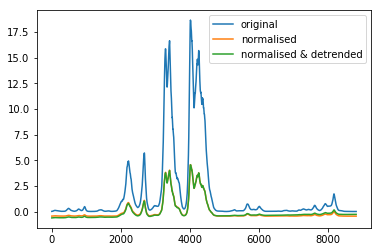

In [10]:
# basic operations
norm = fr.normalize(std=True, inplace=False)
# so, are all temporal means close to zero?
print(np.allclose(norm.data.mean(dim="time"), 0.))
# aand, are all temporal std close to 1?
print(np.allclose(norm.data.std(dim="time"), 1.0))
plt.plot(fr["rates_exc"].data.sel({"space": 0}), label="original")
plt.plot(norm["rates_exc"].data.sel({"space": 0}), label="normalised")

# you can detrend the signal, all of it, or by segments (as indices within the signal)
# let's first normalise (so inplace=False), then detrend (we can inplace=True)
detrended = fr.normalize(std=True, inplace=False)
detrended.detrend(inplace=True)
plt.plot(detrended["rates_exc"].data.sel({"space": 0}), label="normalised & detrended")
detrended_segments = fr.detrend(segments=np.arange(20000, 1000), inplace=False)
plt.legend()

so, the sampling frequency is too high, let's resample

10000.0
1000.0


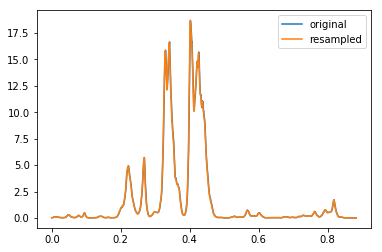

In [11]:
print(fr.sampling_frequency)
plt.plot(fr.data.time, fr["rates_exc"].data.sel({"space": 0}), label="original")
fr.resample(to_frequency=1000., inplace=True)
print(fr.sampling_frequency)
plt.plot(fr.data.time, fr["rates_exc"].data.sel({"space": 0}), label="resampled")
plt.legend()

## More complete example

Let's do a more complete example. Let's say, you run the model and want to extract phase and amplitude of the $\alpha$ band (i.e. 8-12Hz) for some phase-amplitude coupling analyses.

0.0 0.882
-0.5 1.382
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 1651 samples (1.651 sec)

0.0 0.882


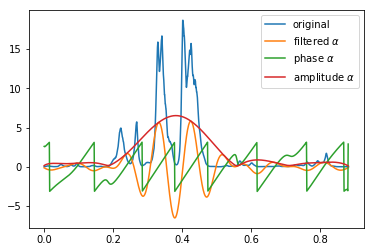

In [12]:
# init again to start fresh
fr = RatesSignal.from_model_output(aln, group="", time_in_ms=True)
plt.plot(fr.data.time, fr["rates_exc"].data.sel({"space": 0}), label="original")

# first resample
fr.resample(to_frequency=1000., inplace=True)

# next detrend
fr.detrend(inplace=True)
print(fr.start_time, fr.end_time)

# next pad with 0s for 0.5 seconds in order to suppress edge effect when filtering
padded = fr.pad(how_much=0.5, in_seconds=True, padding_type="constant", side="both",
                constant_values=0., inplace=False)
print(padded.start_time, padded.end_time)

# now filter - by default uses mne, if not installed, falls back to scipy basic IIR filter
padded.filter(low_freq=8., high_freq=12., inplace=True)

# now cut back the original length
filtered = padded.sel([fr.start_time, fr.end_time], inplace=False)
print(filtered.start_time, filtered.end_time)

plt.plot(filtered.data.time, filtered["rates_exc"].data.sel({"space": 0}), label=r"filtered $\alpha$")

# finally, get phase and amplitude via Hilbert transform
phase = filtered.hilbert_transform(return_as="phase_wrapped", inplace=False)
plt.plot(phase.data.time, phase["rates_exc"].data.sel({"space": 0}), label=r"phase $\alpha$")
amplitude = filtered.hilbert_transform(return_as="amplitude", inplace=False)
plt.plot(amplitude.data.time, amplitude["rates_exc"].data.sel({"space": 0}), label=r"amplitude $\alpha$")
plt.legend()

In [13]:
# in case you forget that happened in the processing, you can easily check all steps:
print(phase.preprocessing_steps)
print(amplitude.preprocessing_steps)

resample to 1000.0Hz -> detrend -> 0.5s constant both sides padding -> filter: low 8.0Hz - high 12.0Hz -> select x:0.882s -> Hilbert - wrapped phase
resample to 1000.0Hz -> detrend -> 0.5s constant both sides padding -> filter: low 8.0Hz - high 12.0Hz -> select x:0.882s -> Hilbert - amplitude


## Saving / loading

In [14]:
# and you can save your signal for future generations! (saved as netCDF file)
phase.save("phase_from_some_experiment")

In [15]:
# and then load it
phase_loaded = RatesSignal.from_file("phase_from_some_experiment")
# compare whether it is the same
print(phase == phase_loaded)
# the attributes are saved/loaded as well
print(phase_loaded.name)
print(phase_loaded.unit)
print(phase_loaded.preprocessing_steps)
# delete file
os.remove("phase_from_some_experiment.nc")

True
Population firing rate
Hz
resample to 1000.0Hz -> detrend -> 0.5s constant both sides padding -> filter: low 8.0Hz - high 12.0Hz -> select x:0.882s -> Hilbert - wrapped phase


## Iterators
Sometimes it is useful to apply or see something in a loop. That's why `Signal` supports both: iterating over space / outputs variables and applying some 1D function over temporal dimensions.

In [16]:
# this will iterate over whole data and return one 1D temporal slice at the time, each slice is Signal class
for name, ts in fr.iterate(return_as="signal"):
    print(name, type(ts), ts.start_time, ts.end_time)
    
# this will iterate over whole data and return one 1D temporal slice at the time, each slice is DataArray
for name, ts in fr.iterate(return_as="xr"):
    print(name, type(ts), ts.shape, ts.shape)

('rates_exc', 0) <class 'neurolib.utils.signal.RatesSignal'> 0.0 0.882
('rates_exc', 1) <class 'neurolib.utils.signal.RatesSignal'> 0.0 0.882
('rates_exc', 2) <class 'neurolib.utils.signal.RatesSignal'> 0.0 0.882
('rates_exc', 3) <class 'neurolib.utils.signal.RatesSignal'> 0.0 0.882
('rates_exc', 4) <class 'neurolib.utils.signal.RatesSignal'> 0.0 0.882
('rates_exc', 5) <class 'neurolib.utils.signal.RatesSignal'> 0.0 0.882
('rates_exc', 6) <class 'neurolib.utils.signal.RatesSignal'> 0.0 0.882
('rates_exc', 7) <class 'neurolib.utils.signal.RatesSignal'> 0.0 0.882
('rates_exc', 8) <class 'neurolib.utils.signal.RatesSignal'> 0.0 0.882
('rates_exc', 9) <class 'neurolib.utils.signal.RatesSignal'> 0.0 0.882
('rates_exc', 10) <class 'neurolib.utils.signal.RatesSignal'> 0.0 0.882
('rates_exc', 11) <class 'neurolib.utils.signal.RatesSignal'> 0.0 0.882
('rates_exc', 12) <class 'neurolib.utils.signal.RatesSignal'> 0.0 0.882
('rates_exc', 13) <class 'neurolib.utils.signal.RatesSignal'> 0.0 0.882
('

In [17]:
# sliding window - let's iterate over temporal windows of 0.5seconds, with 0.1s translation and boxcar window function
for window in fr.sliding_window(length=0.5, step=0.1, window_function="boxcar", lengths_in_seconds=True):
    print(type(window), window.shape, window.start_time, window.end_time)

<class 'neurolib.utils.signal.RatesSignal'> (2, 80, 500) 0.0 0.499
<class 'neurolib.utils.signal.RatesSignal'> (2, 80, 500) 0.1 0.599
<class 'neurolib.utils.signal.RatesSignal'> (2, 80, 500) 0.2 0.699
<class 'neurolib.utils.signal.RatesSignal'> (2, 80, 500) 0.3 0.799


In [18]:
# apply 1D function - Signal supports applying 1D function per temporal slice
# both are supported: function that reduces temporal dimension (e.g. mean which reduces timeseries of length N to one number),
# and functions that preserve shape

# reduce
mean = fr.apply(partial(np.mean, axis=-1), inplace=False)
# mean is now xr.DataArray, not Signal; but the coordinates except time are preserved
print(type(mean), mean.shape, mean.coords)

# preserve shape
absolute_value = fr.apply(np.abs, inplace=False)
# still Signal
print(absolute_value.shape)

<class 'xarray.core.dataarray.DataArray'> (2, 80) Coordinates:
  * output   (output) <U9 'rates_exc' 'rates_inh'
  * space    (space) int64 0 1 2 3 4 5 6 7 8 9 ... 70 71 72 73 74 75 76 77 78 79
(2, 80, 883)


## Functional connectivity

Lot of modelling effort actually goes to fitting the experimental functional connectivity with the modelled one.
That's why `Signal` class supports functional connectivity computation and with other methods (like filtering and iterating over temporal windows) we can even do timeseries of FC or band-specific FC very easily within the couple of lines.

<class 'xarray.core.dataarray.DataArray'> (80, 80) Coordinates:
  * space    (space) int64 0 1 2 3 4 5 6 7 8 9 ... 70 71 72 73 74 75 76 77 78 79


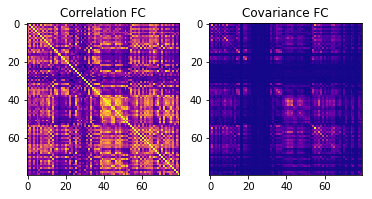

In [19]:
# basic FC from excitatory rates - using correlation
fc_exc = fr["rates_exc"].functional_connectivity(fc_function=np.corrcoef)
# results is DataArray with space coordinates
print(type(fc_exc), fc_exc.shape, fc_exc.coords)
plt.subplot(1,2,1)
plt.title("Correlation FC")
plt.imshow(fc_exc.values)

# FC from covariance
fc_cov_exc = fr["rates_exc"].functional_connectivity(fc_function=np.cov)
plt.subplot(1,2,2)
plt.title("Covariance FC")
plt.imshow(fc_cov_exc.values)

# so fc_function can be any function that can take (nodes x time) array and transform it to (nodes x nodes) connectivity matrix

Processing delta...
Setting up band-pass filter from 2 - 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 1651 samples (1.651 sec)

resample to 1000.0Hz -> detrend -> 0.5s constant both sides padding -> filter: low 2Hz - high 4Hz -> select x:0.882s
Processing theta...
Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidt

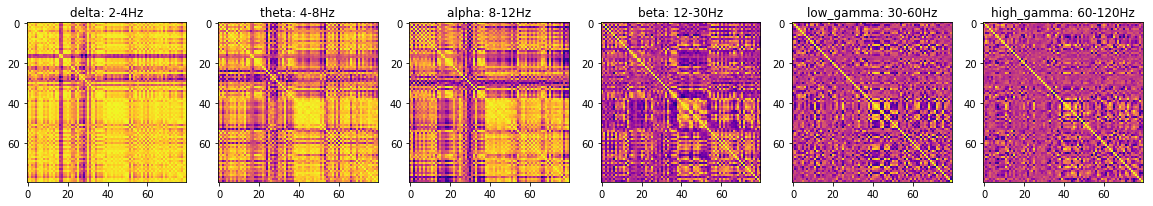

In [20]:
# band-specific FC
BANDS = {
    "delta": {"low_freq": 2, "high_freq": 4},
    "theta": {"low_freq": 4, "high_freq": 8},
    "alpha": {"low_freq": 8, "high_freq": 12},
    "beta": {"low_freq": 12, "high_freq": 30},
    "low_gamma": {"low_freq": 30, "high_freq": 60},
    "high_gamma": {"low_freq": 60, "high_freq": 120},
}
padded = fr.pad(how_much=0.5, in_seconds=True, padding_type="constant", side="both",
                constant_values=0., inplace=False)

plt.figure(figsize=(20, 4))
for ii, (band, filt_spec) in enumerate(BANDS.items()):
    print(f"Processing {band}...")
    filtered = padded.filter(**filt_spec, inplace=False)
    filtered.sel([fr.start_time, fr.end_time], inplace=True)
    plt.subplot(1, len(BANDS), ii + 1)
    fc = filtered["rates_exc"].functional_connectivity(fc_function=np.corrcoef)
    print(filtered.preprocessing_steps)
    plt.imshow(fc)
    plt.title(f"{band}: {filt_spec['low_freq']}-{filt_spec['high_freq']}Hz")
plt.show()

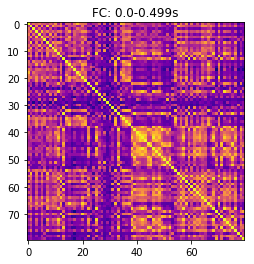

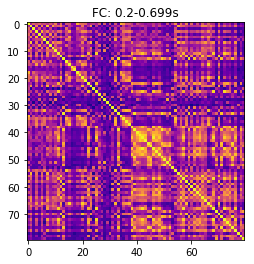

In [21]:
# time-varying FC
for window in fr.sliding_window(length=0.5, step=0.2, window_function="boxcar", lengths_in_seconds=True):
    fc = window["rates_exc"].functional_connectivity(fc_function=np.corrcoef)
    plt.imshow(fc)
    plt.title(f"FC: {window.start_time}-{window.end_time}s")
    plt.show()